# Feature postprocessing from paper.
- Title:  "Predicting yeast synthetic lethal genetic interactions using protein domains"
- Authors: Bo Li, Feng Luo,School of Computing,Clemson University,Clemson, SC, USA
- e-mail: bol, luofeng@clemson.edu
- year:2009 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict 
import seaborn as sns
import matplotlib.cm as cm
import scipy as scipy
import random

### Importing datasets 

#### Link to the github repo where the datasets to be downloaded:
[DOWNLOAD THE DATASETS HERE](https://github.com/leilaicruz/machine-learning-for-yeast/tree/dev_Leila/datasets-for-learning)

In [2]:
import os
script_dir = os.path.dirname('__file__') #<-- absolute dir the script is in
rel_path_SL = "datasets/data-synthetic-lethals.xlsx"
rel_path_nSL="datasets/data-positive-genetic.xlsx"
rel_path_domains="datasets/proteins-domains-from-Pfam.xlsx"

abs_file_path_SL = os.path.join(script_dir, rel_path_SL)
abs_file_path_nSL = os.path.join(script_dir, rel_path_nSL)
abs_file_path_domains = os.path.join(script_dir, rel_path_domains)

os.chdir('../') #<-- for binder os.chdir('../')
my_path_sl= abs_file_path_SL
my_path_non_sl=abs_file_path_nSL
my_path_domains=abs_file_path_domains

data_sl=pd.read_excel(my_path_sl,header=0)
data_domains=pd.read_excel(my_path_domains,header=0,index_col='Unnamed: 0')
data_domains=data_domains.dropna()
data_nonsl=pd.read_excel(my_path_non_sl,header=0)

## Building the feature matrix
One matrix for true SL where each row is one pair of SL. Every raw will be a vector of 0,1 or 2 depending on the comparison with the domain list. For row i the jth element = 0 if the jth element of the domain list is not in neither protein A and B, 1, if it is in one of them and 2 if it is in both of them .

### Building the list of proteins domains id per protein pair separately :
- List of protein A: Search for the Sl/nSL database the query gene name and look in the protein domain database which protein domains id has each of those queries.
- List of protein B: Search for the Sl/nSL database the target gene name of the previous query and look in the protein domain database which protein domains id has each of those target genes.

In [3]:
# Selecting the meaningful columns in the respective dataset
domain_id_list=data_domains['domain-name']
query_gene=data_sl['gene-query-name']
target_gene=data_sl['gene-target-name']
query_gene_nonlethal=data_nonsl['gene-query-name']
target_gene_nonlethal=data_nonsl['gene-target-name']



# Initialising the arrays
protein_a_list=[]
protein_b_list=[]
protein_a_list_non=[]
protein_b_list_non=[]

population = np.arange(0,len(data_sl))

# For loop for 10000 pairs sampled randomly from the SL/nSl pair list , and creating a big array of proteind domains id per protein pair

for m in random.sample(list(population), 10000):
    protein_a=data_domains[data_domains['name']==query_gene[m]]
    protein_b=data_domains[data_domains['name']==target_gene[m]]
    protein_a_list.append(protein_a['domain-name'].tolist())
    protein_b_list.append(protein_b['domain-name'].tolist())

    protein_a_non=data_domains[data_domains['name']==query_gene_nonlethal[m]]
    protein_b_non=data_domains[data_domains['name']==target_gene_nonlethal[m]]
    protein_a_list_non.append(protein_a_non['domain-name'].tolist())
    protein_b_list_non.append(protein_b_non['domain-name'].tolist())

In [ ]:
print('We are going to analyze',len((protein_a_list)) ,'protein pairs, out of',len(data_sl),'SL protein pairs')
print('We are going to analyze',len((protein_a_list_non)) ,'protein pairs, out of',len(data_nonsl),'positive protein pairs')

### Postprocessing #1:  Remove protein pairs from study if either protein in the pair does not contain any domain

In [4]:
def remove_empty_domains(protein_list_search,protein_list_pair):
    index=[]
    for i in np.arange(0,len(protein_list_search)):
        if protein_list_search[i]==[]:
            index.append(i) ## index of empty values for the protein_a_list meaning they dont have any annotated domain

    y=[x for x in np.arange(0,len(protein_list_search)) if x not in index] # a list with non empty values from protein_a list

    protein_list_search_new=[]
    protein_list_pair_new=[]
    for i in y:
        protein_list_search_new.append(protein_list_search[i])
        protein_list_pair_new.append(protein_list_pair[i])
    return protein_list_search_new,protein_list_pair_new

## evaluating the function

protein_a_list_new,protein_b_list_new=remove_empty_domains(protein_a_list,protein_b_list)
protein_a_list_non_new,protein_b_list_non_new=remove_empty_domains(protein_a_list_non,protein_b_list_non)

In [5]:
print('The empty domain in the SL were:', len(protein_a_list)-len(protein_a_list_new), 'out of', len(protein_a_list),'domains')
print('The empty domain in the nSL were:', len(protein_a_list_non)-len(protein_a_list_non_new), 'out of', len(protein_a_list_non),'domains')

The empty domain in the SL were: 667 out of 10000 domains
The empty domain in the nSL were: 714 out of 10000 domains


### Feature engineering: Select from each ordered indexes of domain id list which of them appear once, in both or in any of the domains of each protein pair

#### Define function `get_indexes`

In [6]:
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y] # a function that give the index of whether a value appear in array or not
a=[1,2,2,4,5,6,7,8,9,10]
get_indexes(2,a)

[1, 2]

In [7]:
def feature_building(protein_a_list_new,protein_b_list_new):
    x = np.unique(domain_id_list)
    protein_feat_true=np.zeros(shape=(len(x),len(protein_a_list_new)))
    pair_a_b_array=[]
    for i in np.arange(0,len(protein_a_list_new)):
        index_a=[]
        pair=[protein_a_list_new[i],protein_b_list_new[i]]
        pair_a_b=np.concatenate(pair).ravel()
        pair_a_b_array.append(pair_a_b)

    for i in np.arange(0,len(pair_a_b_array)):  
        array,index,counts=np.unique(pair_a_b_array[i],return_index=True,return_counts=True)
        for k,m in zip(counts,array):
            if k ==2:
                protein_feat_true[get_indexes(m,x),i]=2
                
            if k==1:
                protein_feat_true[get_indexes(m,x),i]=1
            # print(index_a[m],i)
    return protein_feat_true

In [8]:
protein_feat_true=feature_building(protein_b_list_new=protein_b_list_new,protein_a_list_new=protein_a_list_new)
protein_feat_true_pd=pd.DataFrame(protein_feat_true.T)

protein_feat_non_true=feature_building(protein_b_list_new=protein_b_list_non_new,protein_a_list_new=protein_a_list_non_new)
protein_feat_non_true_pd=pd.DataFrame(protein_feat_non_true.T)

### How many ones and twos are in each dataset

In [9]:
index_2_true=protein_feat_true_pd.where(protein_feat_true_pd==2)
index_2_true_count=index_2_true.count(axis=1).sum()

index_1_true=protein_feat_true_pd.where(protein_feat_true_pd==1)
index_1_true_count=index_1_true.count(axis=1).sum()

index_2_nontrue=protein_feat_non_true_pd.where(protein_feat_non_true_pd==2)
index_2_nontrue_count=index_2_nontrue.count(axis=1).sum()

index_1_nontrue=protein_feat_non_true_pd.where(protein_feat_non_true_pd==1)
index_1_nontrue_count=index_1_nontrue.count(axis=1).sum()


print('fraction of twos in the SL array is',index_2_true_count/(len(protein_feat_true_pd.index)*len(protein_feat_true_pd.columns)))
print('fraction of ones in the SL array is',index_1_true_count/(len(protein_feat_true_pd.index)*len(protein_feat_true_pd.columns)))
print('fraction of twos in the PI array is',index_2_nontrue_count/(len(protein_feat_non_true_pd.index)*len(protein_feat_non_true_pd.columns)))
print('fraction of ones in the PI array is',index_1_nontrue_count/(len(protein_feat_non_true_pd.index)*len(protein_feat_non_true_pd.columns)))

fraction of twos in the SL array is 5.497244736308469e-05
fraction of ones in the SL array is 0.0008992174750042726
fraction of twos in the PI array is 4.6991561098819335e-05
fraction of ones in the PI array is 0.0007967917579649806


#### Bar plot to visualize these numbers 

In [ ]:
plt.bar(['fraction of 2 in the nSL','fraction of 1 in the nSL'],[index_2_nontrue_count/(len(protein_feat_non_true_pd.index)*len(protein_feat_non_true_pd.columns)),index_1_nontrue_count/(len(protein_feat_non_true_pd.index)*len(protein_feat_non_true_pd.columns))],alpha=0.6,color=['blue','lightblue']), 

plt.bar(['fraction of 2 in SL ','fraction of 1 in SL'],[index_2_true_count/(len(protein_feat_true_pd.index)*len(protein_feat_true_pd.columns)),index_1_true_count/(len(protein_feat_true_pd.index)*len(protein_feat_true_pd.columns))],alpha=0.6,color=['coral','lightcoral'])

plt.ylabel('Fraction from the population')
plt.yscale('log')
plt.xticks(rotation=40)

#### Adding the labels(response variables) to each dataset

In [10]:
protein_feat_true_pd['lethality']=np.ones(shape=(len(protein_a_list_new)))
protein_feat_non_true_pd['lethality']=np.zeros(shape=(len(protein_a_list_non_new)))

#### Joining both datasets

In [11]:
feature_post=pd.concat([protein_feat_true_pd,protein_feat_non_true_pd],axis=0)
feature_post=feature_post.set_index(np.arange(0,len(protein_a_list_new)+len(protein_a_list_non_new)))
print('The number of features are:',feature_post.shape[1])
print('The number of samples are:',feature_post.shape[0])

The number of features are: 3026
The number of samples are: 18619


### Postprocessing and exploration of the feature matrix of both datasets

In [12]:
mean=feature_post.T.describe().loc['mean']
std=feature_post.T.describe().loc['std']
lethality=feature_post['lethality']

corr_keys=pd.concat([mean,std,lethality],axis=1)

### Viz of the stats 

Text(0.5, 1.08, 'Pairplot to see data dependencies with Lethality')

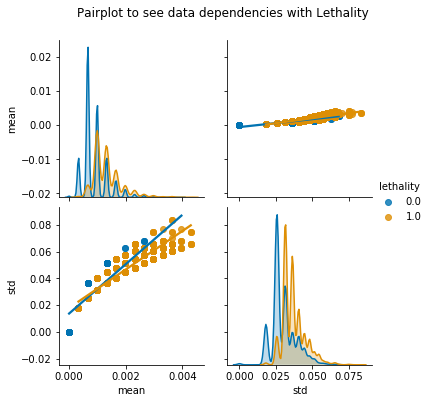

In [13]:
pair=sns.pairplot(corr_keys,hue='lethality',diag_kind='kde',kind='reg',palette='colorblind')
pair.fig.suptitle('Pairplot to see data dependencies with Lethality',y=1.08)

In [14]:
X, y = feature_post.drop(columns=["lethality"]), feature_post["lethality"]

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_sl=protein_feat_true_pd.drop(columns=['lethality'])
x_nsl=protein_feat_non_true_pd.drop(columns=['lethality'])

X_sl_scaled = scaler.fit_transform(x_sl)
X_nsl_scaled = scaler.fit_transform(x_nsl)


In [24]:
np.shape(X_sl_scaled)

(9333, 3025)

In [28]:
def PCA_component_contribution(scaled_matrix,original_data):
    from sklearn.decomposition import PCA

    model = PCA(0.95).fit(scaled_matrix)
    ## apply dimensionality reduction to X_train
    output_pca = model.transform(scaled_matrix)
    
    total=sum(model.explained_variance_)


   
    # number of components
    n_pcs= model.components_.shape[0] # the amount of non redundant protein domains 

    # get the index of the most important feature on EACH component
    # LIST COMPREHENSION HERE
    most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

    initial_feature_names = original_data.columns
    # get the names
    most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
    

    # LIST COMPREHENSION HERE AGAIN
    dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

    # build the dataframe
    df = pd.DataFrame(dic.items(),columns=['pca-component','domain-number'])

    return df,model.components_

In [26]:
df_sl,components_pca_nsl=PCA_component_contribution(X_nsl_scaled,x_nsl)
df_nsl,components_pca_sl=PCA_component_contribution(X_sl_scaled,x_sl)

In [27]:
components_pca_sl.shape

(1420, 3025)

In [29]:
df_shared_domains=pd.merge(df_sl,df_nsl,how='inner',on='domain-number')
domains_name=np.unique(data_domains['domain-name'])
domains_description=np.unique(data_domains['domain-descrip'])

df_shared_domains['domain-description']=domains_description[df_shared_domains['domain-number']]
df_shared_domains


pca-component_x  domain-number pca-component_y  \
0               PC1            540             PC5   
1               PC4           2776             PC6   
2               PC5           2241             PC8   
3               PC6           1671            PC12   
4               PC9            859            PC17   
..              ...            ...             ...   
793          PC1258            280           PC825   
794          PC1250           1174           PC139   
795          PC1256           1174           PC139   
796          PC1255            431          PC1295   
797          PC1257            376          PC1381   

                                    domain-description  
0            Cytochrome_B; Cytochrome b/b6, N-terminal  
1                     Upf2; Up-frameshift suppressor 2  
2       Ribosomal_S5; Ribosomal protein S5, N-terminal  
3    Ofd1_CTDD; Oxoglutarate/iron-dependent oxygena...  
4    FAA_hydrolase; Fumarylacetoacetase, C-terminal...  
..                                                 ...  
793                                  BRCT; BRCT domain  
794               His_biosynth; Histidine biosynthesis  
795               His_biosynth; Histidine biosynthesis  
796      CTU2; Cytoplasmic tRNA 2-thiolation protein 2  
797  COG2; Conserved oligomeric Golgi complex, subu...  

[798 rows x 4 columns]

In [30]:
df_sl_exclusive=pd.merge(df_sl,df_nsl,how='left',on='domain-number')

domains_name=np.unique(data_domains['domain-name'])
domains_description=np.unique(data_domains['domain-descrip'])

df_sl_exclusive['domain-description']=domains_description[df_sl_exclusive['domain-number']]
df_sl_exclusive[pd.isnull(df_sl_exclusive['pca-component_y'])]

pca-component_x  domain-number pca-component_y  \
0                PC0           1028             NaN   
2                PC2            305             NaN   
3                PC3             89             NaN   
7                PC7           1425             NaN   
8                PC8            646             NaN   
...              ...            ...             ...   
1493          PC1248            207             NaN   
1496          PC1251           1389             NaN   
1497          PC1252            521             NaN   
1499          PC1254           2364             NaN   
1504          PC1259           2644             NaN   

                                    domain-description  
0                  GatB_Yqey; Asn/Gln amidotransferase  
2                      Brr6_like_C_C; Brl1/Brr6 domain  
3                                        ANAPC8; Cdc23  
7             Mannosyl_trans; Mannosyltransferase, DXD  
8         DUF1690; Protein of unknown function DUF1690  
...                                                ...  
1493                               Ank; Ankyrin repeat  
1496  MOR2-PAG1_mid; Cell morphogenesis central region  
1497         Cu-oxidase_3; Multicopper oxidase, type 3  
1499         SPC22; Signal peptidase complex subunit 3  
1504        TYW3; tRNA wybutosine-synthesizing protein  

[707 rows x 4 columns]

In [31]:
df_nsl_exclusive=pd.merge(df_sl,df_nsl,how='right',on='domain-number')

domains_name=np.unique(data_domains['domain-name'])
domains_description=np.unique(data_domains['domain-descrip'])

df_nsl_exclusive['domain-description']=domains_description[df_nsl_exclusive['domain-number']]
df_nsl_exclusive[pd.isnull(df_nsl_exclusive['pca-component_x'])]

pca-component_x  domain-number pca-component_y  \
798              NaN           1750             PC0   
799              NaN           1811             PC1   
800              NaN           1464             PC2   
801              NaN            101             PC3   
802              NaN           1373             PC4   
...              ...            ...             ...   
1749             NaN           1868          PC1403   
1750             NaN           1335          PC1404   
1751             NaN           1684          PC1406   
1752             NaN           1886          PC1413   
1753             NaN             86          PC1417   

                                     domain-description  
798                   PH_12; Pleckstrin homology domain  
799   PRAI; N-(5&apos;phosphoribosyl) anthranilate i...  
800   Metallophos_2; Calcineurin-like phosphoesteras...  
801            ARD; Acireductone dioxygenase ARD family  
802    MIS13; Kinetochore-associated protein Dsn1/Mis13  
...                                                 ...  
1749                                      Peptidase_C50  
1750                                LsmAD; LsmAD domain  
1751  P21-Arc; Actin-related protein 2/3 complex sub...  
1752  Peptidase_S10; Peptidase S10, serine carboxype...  
1753  ANAPC4; Anaphase-promoting complex subunit 4 l...  

[956 rows x 4 columns]

## Let see to features that get repeated after finding the Principal components  to describe the data 

In [32]:
duplicated_features_sl=df_sl[df_sl.iloc[:,1].duplicated()]
repeated_features_sl=pd.DataFrame()

domains_name=np.unique(data_domains['domain-name'])
domains_description=np.unique(data_domains['domain-descrip'])

repeated_features_sl['domain-name']=domains_name[duplicated_features_sl.iloc[:,1]] 
repeated_features_sl['domain-description']=domains_description[duplicated_features_sl.iloc[:,1]]

duplicated_features_nsl=df_nsl[df_nsl.iloc[:,1].duplicated()]
repeated_features_nsl=pd.DataFrame()

repeated_features_nsl['domain-name']=domains_name[duplicated_features_nsl.iloc[:,1]] 
repeated_features_nsl['domain-description']=domains_description[duplicated_features_nsl.iloc[:,1]]

In [33]:
repeated_features_nsl

domain-name                                 domain-description
0       PF13967  U1snRNP70_N; U1 small nuclear ribonucleoprotei...
1       PF00394  Alpha-amylase; Glycosyl hydrolase, family 13, ...
2       PF00307  AcetylCoA_hyd_C; Acetyl-CoA hydrolase/transfer...
3       PF02735                             Frag1; Frag1/DRAM/Sfk1
4       PF02772        Fungal_trans_2; Fungal transcription factor
..          ...                                                ...
447     PF05916                              Neugrin; Neugrin/Rrg9
448     PF05916                              Neugrin; Neugrin/Rrg9
449     PF01053                              Chromo; Chromo domain
450     PF02116            ERG2_Sigma1R; ERG2/sigma1 receptor-like
451     PF02116            ERG2_Sigma1R; ERG2/sigma1 receptor-like

[452 rows x 2 columns]

In [34]:
only_sl_pd=pd.merge(repeated_features_sl,repeated_features_nsl,how='left',on=['domain-name'])
data_only_sl = only_sl_pd[pd.isnull(only_sl_pd['domain-description_y'])]
data_only_sl

domain-name                               domain-description_x  \
0       PF08302                       Peptidase_M20; Peptidase M20   
1       PF08302                       Peptidase_M20; Peptidase M20   
2       PF14260                   UBA; Ubiquitin-associated domain   
4       PF13307  TPP_enzyme_C; Thiamine pyrophosphate enzyme, C...   
6       PF00752                  CNH; Citron homology (CNH) domain   
..          ...                                                ...   
499     PF09145  RTP1_C2; RNA polymerase II assembly factor Rtp...   
500     PF00416                                Ank; Ankyrin repeat   
501     PF09445                  ResIII; Helicase/UvrB, N-terminal   
502     PF03810               His_biosynth; Histidine biosynthesis   
503     PF00579                                  BRCT; BRCT domain   

    domain-description_y  
0                    NaN  
1                    NaN  
2                    NaN  
4                    NaN  
6                    NaN  
..                   ...  
499                  NaN  
500                  NaN  
501                  NaN  
502                  NaN  
503                  NaN  

[409 rows x 3 columns]

In [35]:
only_nsl_pd=pd.merge(repeated_features_sl,repeated_features_nsl,how='right',on=['domain-name'])
data_only_nsl = only_nsl_pd[pd.isnull(only_nsl_pd['domain-description_x'])]
data_only_nsl

domain-name domain-description_x  \
95      PF13967                  NaN   
96      PF00394                  NaN   
97      PF00307                  NaN   
98      PF02772                  NaN   
99      PF01321                  NaN   
..          ...                  ...   
484     PF01053                  NaN   
485     PF01053                  NaN   
486     PF01053                  NaN   
487     PF01053                  NaN   
488     PF13423                  NaN   

                                  domain-description_y  
95   U1snRNP70_N; U1 small nuclear ribonucleoprotei...  
96   Alpha-amylase; Glycosyl hydrolase, family 13, ...  
97   AcetylCoA_hyd_C; Acetyl-CoA hydrolase/transfer...  
98         Fungal_trans_2; Fungal transcription factor  
99                                DKCLD; Dyskerin-like  
..                                                 ...  
484                              Chromo; Chromo domain  
485                              Chromo; Chromo domain  
486                              Chromo; Chromo domain  
487                              Chromo; Chromo domain  
488  TRAPP; Transport protein particle (TRAPP) comp...  

[394 rows x 3 columns]

In [36]:
shared_domains_pd=pd.merge(repeated_features_sl,repeated_features_nsl,how='inner',on=['domain-name'])
shared_domains_pd



domain-name                               domain-description_x  \
0      PF02735                             Frag1; Frag1/DRAM/Sfk1   
1      PF02866  GIT1_C; ARF GTPase-activating protein GIT1, C-...   
2      PF00240               ATG_C; Autophagy-related, C-terminal   
3      PF05397             NAP; Nucleosome assembly protein (NAP)   
4      PF01729        DUF4208; Domain of unknown function DUF4208   
..         ...                                                ...   
90     PF02940       GTP_cyclohydroI; GTP cyclohydrolase I domain   
91     PF03902  Hyphal_reg_CWP; Hyphally-regulated cell wall p...   
92     PF00719                  CHZ; Histone chaperone domain CHZ   
93     PF00719                  CHZ; Histone chaperone domain CHZ   
94     PF04136                       LRR_4; Leucine rich repeat 4   

                                 domain-description_y  
0                              Frag1; Frag1/DRAM/Sfk1  
1   GIT1_C; ARF GTPase-activating protein GIT1, C-...  
2                ATG_C; Autophagy-related, C-terminal  
3              NAP; Nucleosome assembly protein (NAP)  
4         DUF4208; Domain of unknown function DUF4208  
..                                                ...  
90       GTP_cyclohydroI; GTP cyclohydrolase I domain  
91  Hyphal_reg_CWP; Hyphally-regulated cell wall p...  
92                  CHZ; Histone chaperone domain CHZ  
93                  CHZ; Histone chaperone domain CHZ  
94                       LRR_4; Leucine rich repeat 4  

[95 rows x 3 columns]

(0, 0.2)

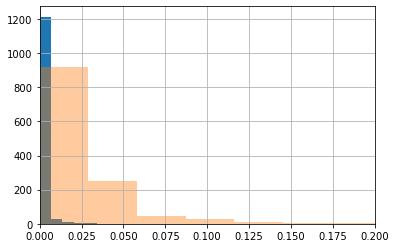

In [47]:
a_sl=x_sl.iloc[:,np.sort(df_sl.iloc[:,1])]
a_sl.describe().loc['mean'].hist(bins=8),
a_sl.describe().loc['std'].hist(bins=8,alpha=0.4)
plt.xlim([0,0.2])

(0, 0.2)

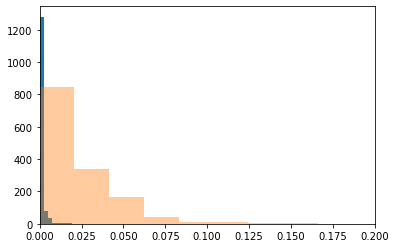

In [46]:
a_nsl=x_nsl.iloc[:,np.sort(df_nsl.iloc[:,1])]
plt.hist(a_nsl.describe().loc['mean'],bins=8),
plt.hist(a_nsl.describe().loc['std'],bins=8,alpha=0.4);
plt.xlim([0,0.2])